In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Checking for missing values
train_df.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
# Dropping rows with missing keywords or locations 
train_df = train_df.dropna(subset=['keyword', 'location'])

# Reseting index after dropping
train_df.reset_index(drop=True, inplace=True)

# Checking new shape of the data
train_df.shape


(5080, 5)

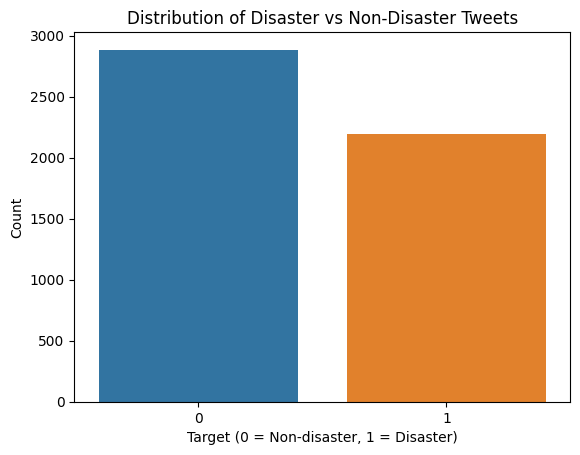

target
0    2884
1    2196
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the target distribution
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

# Displaying counts as text
print(train_df['target'].value_counts())


Number of unique keywords: 221


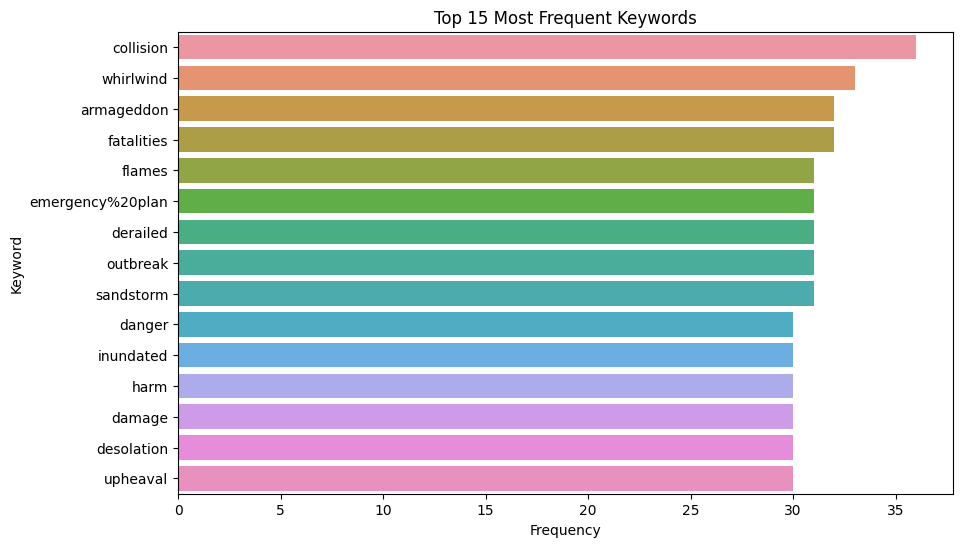

In [6]:
# How many unique keywords?
print("Number of unique keywords:", train_df['keyword'].nunique())

# Most frequent keywords
top_keywords = train_df['keyword'].value_counts().head(15)

# Plotting top keywords
plt.figure(figsize=(10,6))
sns.barplot(y=top_keywords.index, x=top_keywords.values)
plt.title('Top 15 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()


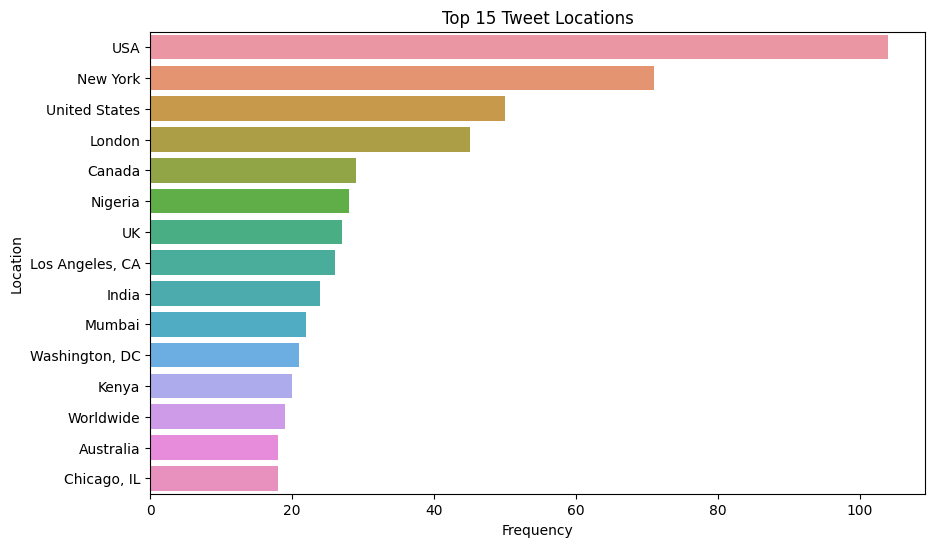

In [7]:
# Top 15 locations
top_locations = train_df['location'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_locations.index, x=top_locations.values)
plt.title('Top 15 Tweet Locations')
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

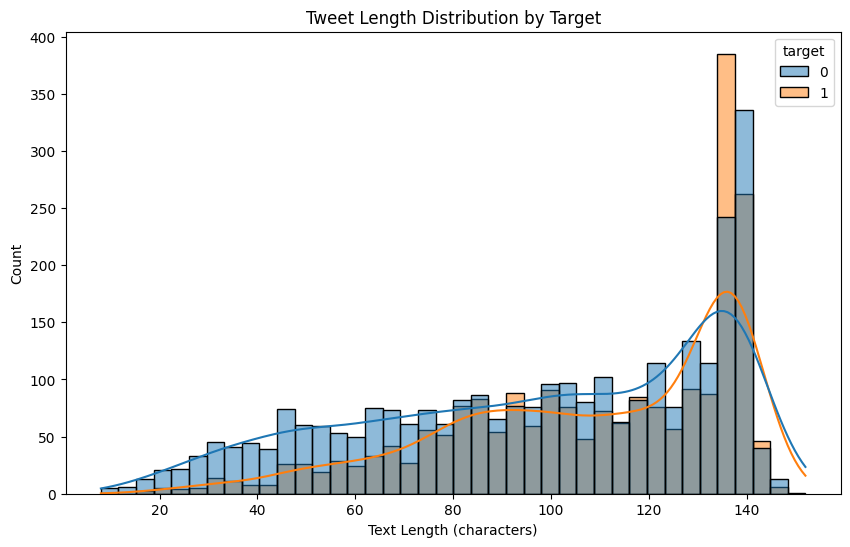

In [8]:
# Creating new features
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plotting tweet length distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=40, kde=True)
plt.title('Tweet Length Distribution by Target')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()


In [9]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Downloading stopwords if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                                # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # removing URLs
    text = re.sub(r'\@w+|\#','', text)                 # removing mentions and hashtags
    text = re.sub(r'\d+', '', text)                    # removing numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # removing punctuation
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

# Applying cleaning
train_df['clean_text'] = train_df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
train_df[['text', 'clean_text']].head(5)


,text,clean_text
0,@bbcmtd Wholesale Markets ablaze http://t.co/l...,bbcmtd wholesal market ablaz
1,We always try to bring the heavy. #metal #RT h...,alway tri bring heavi metal rt
2,#AFRICANBAZE: Breaking news:Nigeria flag set a...,africanbaz break newsnigeria flag set ablaz aba
3,Crying out for more! Set me ablaze,cri set ablaz
4,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,plu side look sky last night ablaz


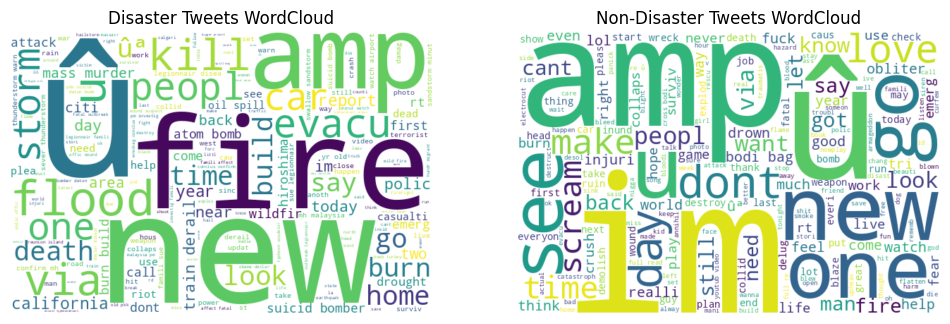

In [11]:
from wordcloud import WordCloud

# Separating clean texts by class
disaster_tweets = train_df[train_df['target'] == 1]['clean_text']
non_disaster_tweets = train_df[train_df['target'] == 0]['clean_text']

# Generating WordClouds
plt.figure(figsize=(12,6))
wordcloud1 = WordCloud(width=600, height=400, background_color='white').generate(" ".join(disaster_tweets))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets WordCloud')

wordcloud0 = WordCloud(width=600, height=400, background_color='white').generate(" ".join(non_disaster_tweets))
plt.subplot(1, 2, 2)
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets WordCloud')
plt.show()


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can try 10,000 later

# Fit on training clean text and transform
X = tfidf.fit_transform(train_df['clean_text'])

# Targeting labels
y = train_df['target']


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on validation set
y_pred = model.predict(X_val)

# Evaluating
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.7903543307086615

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       580
           1       0.81      0.66      0.73       436

    accuracy                           0.79      1016
   macro avg       0.80      0.77      0.78      1016
weighted avg       0.79      0.79      0.79      1016



In [14]:
# Cleaning test data using the same function
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Transforming test data using the same TF-IDF (never fit again!)
X_test = tfidf.transform(test_df['clean_text'])

# Making predictions
test_preds = model.predict(X_test)

# Preparing submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds
})

# Saving to CSV
submission.to_csv('submission.csv', index=False)
